#  ARIMA fault detection algorithm

Pipeline for the anomaly detection on the SKAB. 

The idea behind this algorithm is to use ARIMA weights as features for the anomaly detection algorithm. Using discrete differences of weight coefficients for different heuristic methods for obtaining function, which characterized the state (anomaly, not anomaly) using a threshold. 

Links at [PyPi](https://pypi.org/project/arimafd/), [GitHub](https://github.com/waico/arimafd) and [paper](https://waico.ru)

In [1]:
# libraries importing
import pandas as pd
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import pickle
from itertools import product
from sympy import diff, symbols, sympify, Symbol, poly
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from time import time
import matplotlib.gridspec as gridspec

# additional modules
import sys
sys.path.append('../utils')


## Data loading

In [2]:
# benchmark files checking
all_files=[]
import os
for root, dirs, files in os.walk("../data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

In [3]:
# datasets with anomalies loading
list_of_df = [pd.read_csv(file, 
                          sep=';', 
                          index_col='datetime', 
                          parse_dates=True) for file in all_files if 'anomaly-free' not in file]
# anomaly-free df loading
anomaly_free_df = pd.read_csv([file for file in all_files if 'anomaly-free' in file][0], 
                            sep=';', 
                            index_col='datetime', 
                            parse_dates=True)
true_cp = [df.changepoint for df in list_of_df]

## Data description and visualization

In [4]:
# dataset characteristics printing
print(f'A number of datasets in the SKAB v0.9: {len(list_of_df)}\n')
print(f'Shape of the random dataset: {list_of_df[0].shape}\n')
n_cp = sum([len(df[df.changepoint==1.]) for df in list_of_df])
n_outlier = sum([len(df[df.anomaly==1.]) for df in list_of_df])
print(f'A number of changepoints in the SKAB v0.9: {n_cp}\n')
print(f'A number of outliers in the SKAB v0.9: {n_outlier}\n')
print(f'Head of the random dataset:')
display(list_of_df[0].head())

A number of datasets in the SkAB v1.0: 51

Shape of the random dataset: (745, 10)

A number of changepoints in the SkAB v1.0: 191

A number of outliers in the SkAB v1.0: 19613

Head of the random dataset:


,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
datetime,,,,,,,,,,
2020-03-01 15:44:06,0.082065,0.133521,1.27794,0.054711,92.2562,22.2577,209.639,76.0197,0.0,0.0
2020-03-01 15:44:07,0.082724,0.132378,1.12118,-0.273216,92.0144,22.2577,221.250,76.9806,0.0,0.0
2020-03-01 15:44:08,0.081648,0.139038,1.93242,0.054711,92.2413,22.2748,236.615,76.0197,0.0,0.0
2020-03-01 15:44:09,0.083335,0.132742,1.25962,-0.273216,92.2438,22.2657,230.375,77.0000,0.0,0.0
2020-03-01 15:44:10,0.082272,0.133171,1.59773,0.054711,92.3611,22.2591,249.701,77.0000,0.0,0.0


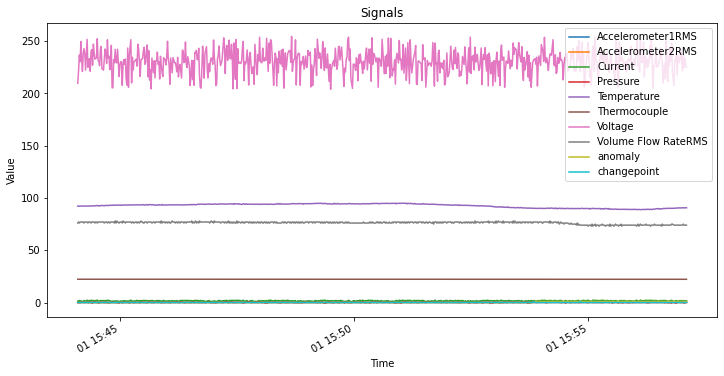

In [5]:
# random dataset visualizing
list_of_df[0].plot(figsize=(12,6))
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Signals')
plt.show()

## Labels

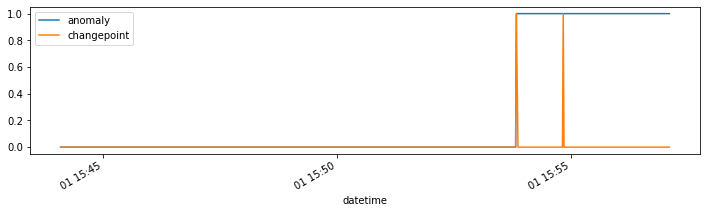

In [6]:
# plotting the labels both for outlier and changepoint detection problems
list_of_df[0].anomaly.plot(figsize=(12,3))
list_of_df[0].changepoint.plot()
plt.legend()
plt.show()

## Method applying

In [7]:
from arimafd import *
import os

In [8]:
if os.path.exists(r'tensors.pickle'):
    with open(r'tensors.pickle', 'rb') as f:
        tensors = pickle.load(f)
else:
    tensors = []
    for df in list_of_df:
        a = Anomaly_detection(df.iloc[:,:-2])
        tensors.append(a.generate_tensor(ar_order=100))
    with open(r'tensors.pickle', 'wb') as handle:
        pickle.dump(tensors, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [28]:
metrics = range(1,6)
windows= [20,50,100,150]
window_insensitivitys = [20,50,100,150]
history = []
from tsad.evaluating.evaluating import evaluating 

for No_metric,window,window_insensitivity in product(metrics,windows,window_insensitivitys):
    print('XXX',No_metric,window,window_insensitivity)
    predicted_cp=[]
    predicted_cp1 = []
    for i,df in enumerate(list_of_df):
        acci = df.changepoint
        a = Anomaly_detection(df)
        a.tensor = tensors[i]
        a.proc_tensor(No_metric=No_metric, window=window, window_insensitivity=window_insensitivity)
        predicted_cp.append(a.bin_metric)
    nab = evaluating(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')
    history.append([No_metric, window, window_insensitivity, nab['Standart'], nab['LowFP'], nab['LowFN']])
    print(history)
    print()
    print()
history = pd.DataFrame(history, columns=['No_metric','window','window_insensitivity','Standart','LowFP','LowFN'])

XXX 1 20 20
Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  0.09
LowFP  -  -1.53
LowFN  -  0.94
[[1, 20, 20, 0.09, -1.53, 0.94]]




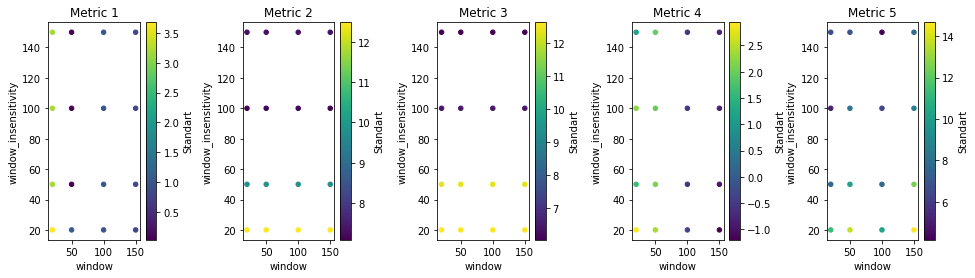

In [11]:
f = plt.figure(figsize=(16,4))
grid = gridspec.GridSpec(1, len(metrics),wspace =0.7)
for i in metrics:
    globals()['ax'+str(i)] = f.add_subplot(grid[i-1])
    history[history.No_metric==i].plot.scatter(x='window',y='window_insensitivity', c='Standart', colormap='viridis',ax=globals()['ax'+str(i)])
    globals()['ax'+str(i)].set_title(f"Metric {i}")
    
plt.show()

In [12]:
No_metric= 5
window= 150
window_insensitivity = 20

predicted_cp=[]
for i,df in enumerate(list_of_df):
    acci = df.changepoint
    a = Anomaly_detection(df)
    a.tensor = tensors[i]
    a.proc_tensor(No_metric=No_metric,window=window, window_insensitivity=window_insensitivity)
    predicted_cp.append(a.bin_metric)

## Results of evaluation 

In [17]:
from tsad.evaluating.evaluating import evaluating

Links at [PyPi](https://pypi.org/project/tsad/), [GitHub](https://github.com/waico/tsad) and [documentation](https://tsad.readthedocs.io/en/latest/Evaluating.html)

In [24]:
nab = evaluating(true_cp, predicted_cp, metric='nab', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Standart  -  7.67
LowFP  -  1.97
LowFN  -  11.04


In [25]:
add = evaluating(true_cp, predicted_cp, metric='average_time', numenta_time='30 sec')

Intersection of scoring windows(Timestamp('2020-02-08 18:20:42'), Timestamp('2020-02-08 18:20:16'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 18:51:37'), Timestamp('2020-02-08 18:51:25'))
Intersection of scoring windows(Timestamp('2020-02-08 19:26:28'), Timestamp('2020-02-08 19:26:07'))
Intersection of scoring windows(Timestamp('2020-02-08 17:17:12'), Timestamp('2020-02-08 17:16:43'))
Intersection of scoring windows(Timestamp('2020-02-08 17:24:11'), Timestamp('2020-02-08 17:23:44'))
Amount of true anomalies 191
A number of missed CPs = 157
A number of FPs = 181
Average time 0 days 00:00:15.323529411
